<a href="https://colab.research.google.com/github/Maria-Ul/YellowRailwayCar-Detection/blob/main/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !curl https://drive.google.com/drive/folders/1yH2gUUZAw6jHL3a_0X6u-gT1-CPLFU-f  -o dataset

In [3]:
path_to_zip_file = '/content/drive/MyDrive/радиоавионика/wide_imgs.zip'
directory_to_extract_to = '/content/data'


In [4]:
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)


In [5]:
!mkdir /content/data/images

In [6]:
!mkdir /content/data/labels

In [7]:
! for f in $(find "/content/data" -name '*.jpg' ); do mv $f "/content/data/images/." ; done


In [8]:
! for f in $(find "/content/data" -name '*.txt' ); do mv $f "/content/data/labels/." ; done


In [9]:
!mv /content/data/labels/classes.txt  /content/data/classes.txt

# анализ данных

In [10]:
import os

In [11]:
labels_dir = "/content/data/labels"
images_dir = "/content/data/images"
labels = os.listdir(labels_dir)
images = os.listdir(images_dir)

In [12]:
len(labels), len(images)

(816, 816)

In [13]:
class_counts = {}
for label in labels:
  label_name = os.path.join(labels_dir, label)
  with open(label_name) as f:
    lines = f.readlines()

    for line in lines:
      line = line.split()
      class_name = line[0]
      if class_name not in class_counts:
          class_counts[class_name] = 1
      else:
          class_counts[class_name] += 1

# Вывод статистики
print("Количество классов:", len(class_counts))
for class_name, count in class_counts.items():
    print(class_name, ":", count)

Количество классов: 1
2 : 1143


# заменим номер класса 2 на 0, чтобы учить yolo на одном классе





In [14]:
!mkdir '/content/labels_original'

In [15]:
!mv /content/data/labels /content/labels_original

In [16]:
!mkdir /content/data/labels

In [17]:
label_dir_correct = "/content/data/labels"
labels_dir = '/content/labels_original/labels'
labels = os.listdir(labels_dir)

In [18]:
for label in labels:
    label_name = os.path.join(labels_dir, label)
    with open(label_name) as f:
      lines = f.readlines()
      correct_lines = []
      for line in lines:
          line = line.split()

          if line[0]=='2':
              line[0]=0
          correct_lines.append(line)
    f.close()
    full_name = os.path.join(label_dir_correct, label)
    f = open(full_name, 'a')
    for line in correct_lines:
        # print(line)
        label, xmin, ymin, w, h = line[0], line[1], line[2], line[3], line[4]
        line = f"{label} {xmin} {ymin} {w} {h} \n"
        f.write(line)

# разделим данные на подвыборки

In [19]:
import random

In [20]:
labels_dir = "/content/data/labels"
images_dir = "/content/data/images"
labels = os.listdir(labels_dir)
images = os.listdir(images_dir)

In [21]:
from sklearn.model_selection import train_test_split
# Read images and annotations
images = [os.path.join(images_dir, x) for x in images]
labels = [os.path.join(labels_dir, x) for x in labels]

images.sort()
labels.sort()

# Split the dataset into train-valid-test splits
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.3, random_state = 1)
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size = 0.5, random_state = 1)

In [22]:
len(train_images), len(val_images), len(test_images)

(571, 122, 123)

In [23]:
train_images[0]

'/content/data/images/img_kjtv_197_sec.jpg'

In [24]:
train_labels[0]

'/content/data/labels/img_kjtv_197_sec.txt'

In [25]:
!mkdir /content/data/images/train /content/data/images/val /content/data/images/test /content/data/labels/train /content/data/labels/val /content/data/labels/test


In [26]:
import shutil

#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/content/data/images/train')
move_files_to_folder(val_images, '/content/data/images/val/')
move_files_to_folder(test_images, '/content/data/images/test/')
move_files_to_folder(train_labels, '/content/data/labels/train/')
move_files_to_folder(val_labels, '/content/data/labels/val/')
move_files_to_folder(test_labels, '/content/data/labels/test/')

добавим data.yaml

```
train: /content/data/images/train
val: /content/data/images/val
test: /content/data/images/test

# number of classes
nc: 1

# class names
names: ["railwaycar"]
```



# обучим yolo

подключим лог

In [27]:
!pip install clearml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [28]:
import clearml
clearml.browser_login()

<IPython.core.display.Javascript object>


🤖 ClearML connected successfully - let's build something! 🚀


In [29]:
!clearml-init

ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
api {   # Mariya Ulyanova's workspace   web_server: https://app.clear.ml   api_server: https://api.clear.ml   files_server: https://files.clear.ml   credentials {     "access_key" = "0LACVB9IYDOKROTQGSJJ"     "secret_key" = "rXYPH7YuEQEFvcmjXxnbcOd9oZWrQfXh4m7yS6gHwJQ1hnECFF"   } }
Detected credentials key="0LACVB9IYDOKROTQGSJJ" secret="rXYP***"

ClearML Hosts configuration:
Web App: https://app.clear.ml
API: https://api.clear.ml
File Store: https://files.clear.ml

Verifying credentials ...
Credentials verified!

New configuration stored in /root/clearml.conf
ClearML setup completed successfully.


In [30]:
from clearml import Task

In [31]:
task = Task.init(project_name='radioavionika_test_task', task_name='yolo8n_train_val_test')

ClearML Task: created new task id=3ef233142cba46388e1d91dcb1d21c75
2023-10-18 19:10:42,657 - clearml.Task - INFO - No repository found, storing script code instead


ClearML results page: https://app.clear.ml/projects/e4cf88d5f00b46aaa0e77e84291952a7/experiments/3ef233142cba46388e1d91dcb1d21c75/output/log


In [32]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 9.4 MB/s eta 0:00:00


100%|██████████| 6.23M/6.23M [00:00<00:00, 82.1MB/s]


2023-10-18 19:10:58,686 - clearml.model - INFO - Selected model id: 2f72d5367d92437f9badf10c62ab0234


Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=15, patience=10, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fals

2023-10-18 19:21:28,773 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/radioavionika_test_task/yolo8n_train_val_test.3ef233142cba46388e1d91dcb1d21c75/models/best.pt


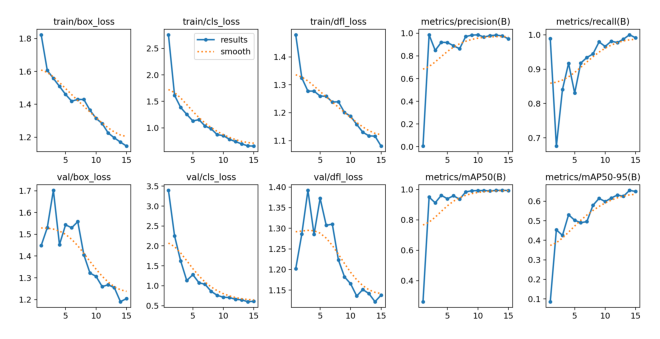

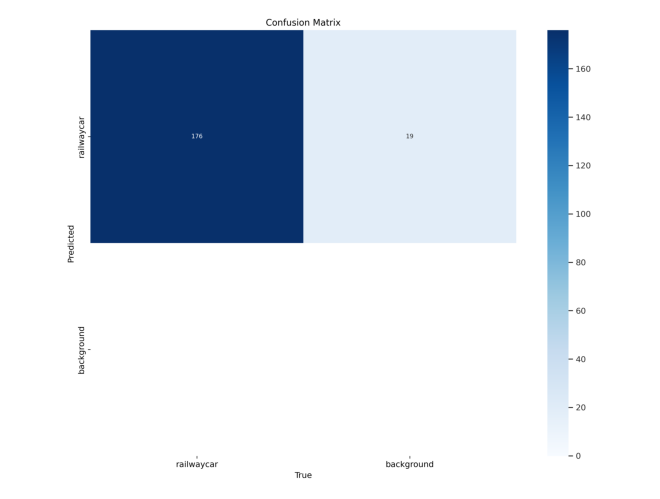

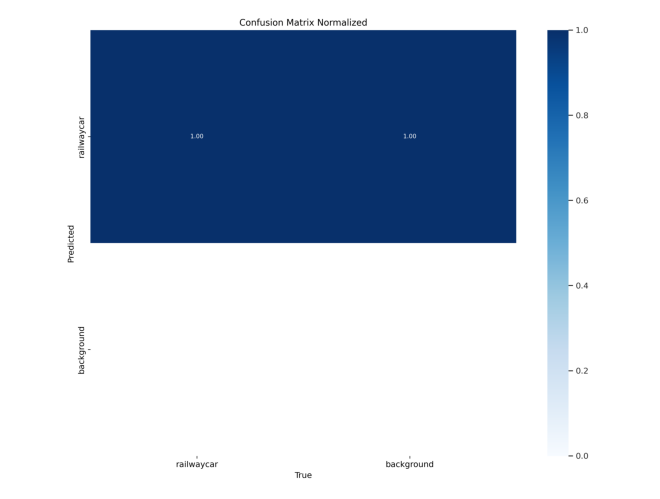

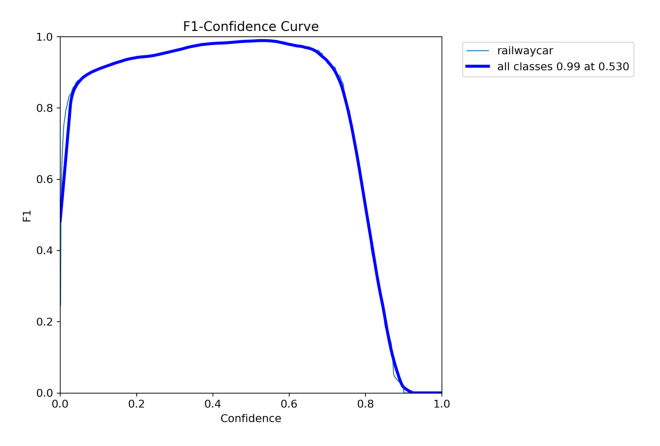

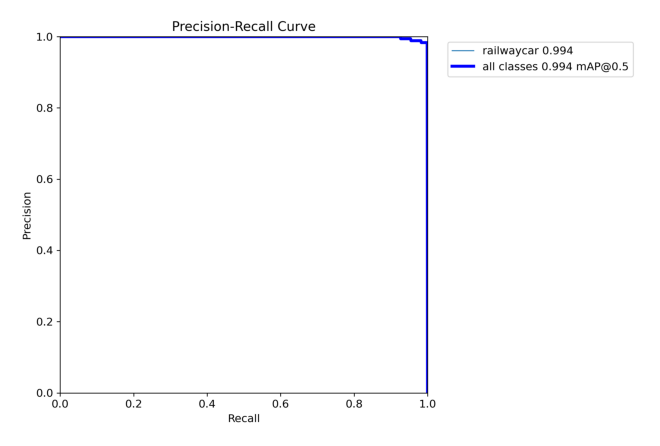

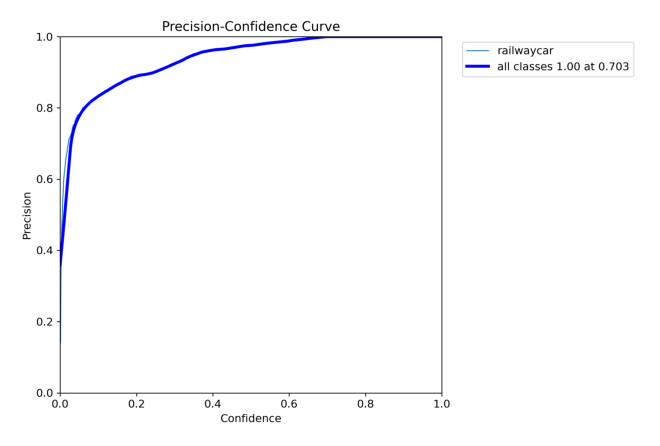

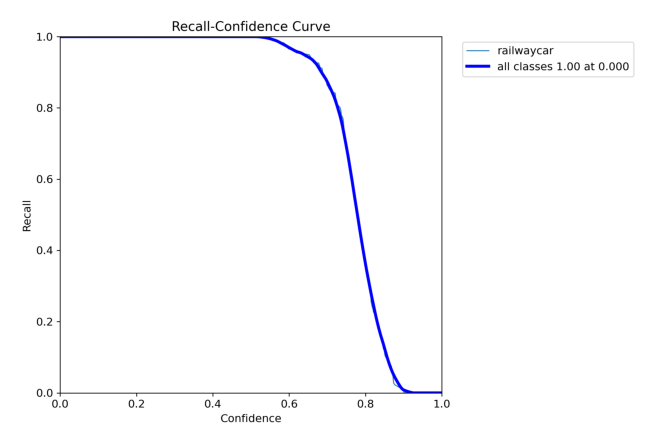

In [33]:
from ultralytics import YOLO
# Load a model
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
# Train the model
# results = model.train(data='data.yaml', epochs=10, imgsz=640)
results = model.train(data='/content/data.yaml', epochs=15, imgsz=640, patience = 10, save_period = 5)


In [35]:
# Load a model
model = YOLO('/content/runs/detect/train/weights/best.pt')  # load a custom model

# Validate the model
# metrics = model.val(name='validation')  # no arguments needed, dataset and settings remembered
metrics = model.val(augment = True)  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category


Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/data/labels/val.cache... 122 images, 0 backgrounds, 0 corrupt: 100%|██████████| 122/122 [00:00<?, ?it/s]
Exception ignored in: <function _after_at_fork_child_reinit_locks at 0x7c31a78665f0>
Exception ignored in: Traceback (most recent call last):
<function _after_at_fork_child_reinit_locks at 0x7c31a78665f0>  File "/usr/lib/python3.10/logging/__init__.py", line 256, in _after_at_fork_child_reinit_locks

    Traceback (most recent call last):
handler._at_fork_reinit()  File "/usr/lib/python3.10/logging/__init__.py", line 256, in _after_at_fork_child_reinit_locks

    handler._at_fork_reinit()  File "/usr/lib/python3.10/logging/__init__.py", line 910, in _at_fork_reinit
    
self.lock._at_fork_reinit()  File "/usr/lib/python3.10/logging/__init__.py", line 910, in _at_fork_reinit

                 Clas

array([    0.65975])

In [36]:
results = model.predict("/content/data/images/test", save = True)


image 1/123 /content/data/images/test/img_kjtv_0_sec.jpg: 384x640 3 railwaycars, 210.8ms
image 2/123 /content/data/images/test/img_kjtv_1019_sec.jpg: 384x640 2 railwaycars, 16.0ms
image 3/123 /content/data/images/test/img_kjtv_1028_sec.jpg: 384x640 2 railwaycars, 12.1ms
image 4/123 /content/data/images/test/img_kjtv_1030_sec.jpg: 384x640 2 railwaycars, 7.1ms
image 5/123 /content/data/images/test/img_kjtv_1055_sec.jpg: 384x640 2 railwaycars, 6.8ms
image 6/123 /content/data/images/test/img_kjtv_1056_sec.jpg: 384x640 2 railwaycars, 8.0ms
image 7/123 /content/data/images/test/img_kjtv_1061_sec.jpg: 384x640 2 railwaycars, 6.9ms
image 8/123 /content/data/images/test/img_kjtv_106_sec.jpg: 384x640 2 railwaycars, 6.3ms
image 9/123 /content/data/images/test/img_kjtv_1074_sec.jpg: 384x640 2 railwaycars, 6.4ms
image 10/123 /content/data/images/test/img_kjtv_1078_sec.jpg: 384x640 2 railwaycars, 6.5ms
image 11/123 /content/data/images/test/img_kjtv_1079_sec.jpg: 384x640 2 railwaycars, 6.5ms
image 1

# скачаем результат

In [37]:
from google.colab import files
import os

dir_to_zip = '/content/runs' #@param {type: "string"}
output_filename = 'runs.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

заокнчим логгирование clear-ml

In [38]:
task.close()

# тест на оригинальных весах yolo

In [8]:
task = Task.init(project_name='radioavionika_test_task', task_name='yolo8n_original_weights_test')

In [11]:
# Load a model
model = YOLO('yolov8n.pt')

2023-10-18 14:55:57,028 - clearml.model - INFO - Selected model id: 2f72d5367d92437f9badf10c62ab0234


In [14]:
results = model.predict("/content/data/images/test", save = True)


image 1/123 /content/data/images/test/img_kjtv_0_sec.jpg: 384x640 1 person, 2 trains, 43.6ms
image 2/123 /content/data/images/test/img_kjtv_1019_sec.jpg: 384x640 1 bench, 16.2ms
image 3/123 /content/data/images/test/img_kjtv_1028_sec.jpg: 384x640 (no detections), 11.3ms
image 4/123 /content/data/images/test/img_kjtv_1030_sec.jpg: 384x640 (no detections), 9.7ms
image 5/123 /content/data/images/test/img_kjtv_1055_sec.jpg: 384x640 1 tv, 8.3ms
image 6/123 /content/data/images/test/img_kjtv_1056_sec.jpg: 384x640 (no detections), 10.7ms
image 7/123 /content/data/images/test/img_kjtv_1061_sec.jpg: 384x640 1 person, 1 skateboard, 7.7ms
image 8/123 /content/data/images/test/img_kjtv_106_sec.jpg: 384x640 1 person, 2 trains, 1 bench, 8.3ms
image 9/123 /content/data/images/test/img_kjtv_1074_sec.jpg: 384x640 1 person, 8.7ms
image 10/123 /content/data/images/test/img_kjtv_1078_sec.jpg: 384x640 2 persons, 1 train, 8.2ms
image 11/123 /content/data/images/test/img_kjtv_1079_sec.jpg: 384x640 (no detec

In [15]:
task.close()

In [16]:
from google.colab import files
import os

dir_to_zip = '/content/runs/detect/predict' #@param {type: "string"}
output_filename = 'predict.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>